In [6]:
pwd

'/Users/Ted/Documents/GitHub/tss-ml/notebooks'

In [30]:
import sys
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

# Project files
import config, data, train, models, evaluate

importlib.reload(config)
from config import format_config
cfg = {
    # Data
    "data_dir": "../data/Sag",
    "basin_file": "sites.txt",  
    "features": {"daily": ["gage_Q"],
                 "irregular": ["Blue", "Green", "Red", "Nir", "Swir1", "Swir2"],
                 "static": None, # All are used when None
                 "target": "tss"},
    "time_slice": ["1979-01-01", "2018-12-31"], 
    "split_time": "2010-01-01",
    "sequence_length": 30,
    "log_norm_cols": ["tss","gage_Q"],
    "clip_target_to_zero": True,
    
    # DataLoader
    "shuffle": True,
    "batch_size": 32,
    "data_subset": "train",
    "num_workers": 0,
    "pin_memory": True, 
    
    # Model
    "model": "taplstm",
    "model_args": {"hidden_size": 64,
                   "dropout": 0.4,
                   "seed": 0}, 
    
    # Trainer
    "log_interval": 1,
    "num_epochs": 10,
    "initial_lr": 0.01,
    "decay_rate": 0.01,
    "step_kwargs":{"loss": "mse",
                   "max_grad_norm": 2}, 
    
    # Misc
    "quiet": False,  # Use to declutter the slurm output (removes tqdm)
    "log": False # Recording training progress
}
cfg = format_config(cfg)
cfg

{'data_dir': PosixPath('/Users/Ted/Documents/GitHub/tss-ml/data/Sag'),
 'basin_file': PosixPath('/Users/Ted/Documents/GitHub/tss-ml/data/Sag/sites.txt'),
 'features': {'daily': ['gage_Q'],
  'irregular': ['Blue', 'Green', 'Red', 'Nir', 'Swir1', 'Swir2'],
  'static': None,
  'target': 'tss'},
 'time_slice': slice('1979-01-01', '2018-12-31', None),
 'split_time': numpy.datetime64('2010-01-01'),
 'sequence_length': 30,
 'log_norm_cols': ['tss', 'gage_Q'],
 'clip_target_to_zero': True,
 'shuffle': True,
 'batch_size': 32,
 'data_subset': 'train',
 'num_workers': 0,
 'pin_memory': True,
 'model': 'taplstm',
 'model_args': {'hidden_size': 64, 'dropout': 0.4, 'seed': 0, 'out_size': 1},
 'log_interval': 1,
 'num_epochs': 10,
 'initial_lr': 0.01,
 'decay_rate': 0.01,
 'step_kwargs': {'loss': 'mse', 'max_grad_norm': 2},
 'quiet': False,
 'log': False}

In [31]:
importlib.reload(data)
from data import TAPDataset

dataset = TAPDataset(cfg)

Loading Basins:   0%|          | 0/2 [00:00<?, ?it/s]

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


Epoch:001:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:002:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:003:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:004:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:005:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:006:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:007:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:008:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:009:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:010:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:011:   0%|          | 0/5 [00:00<?, ?it/s]

Training finished or interrupted. Model state saved.


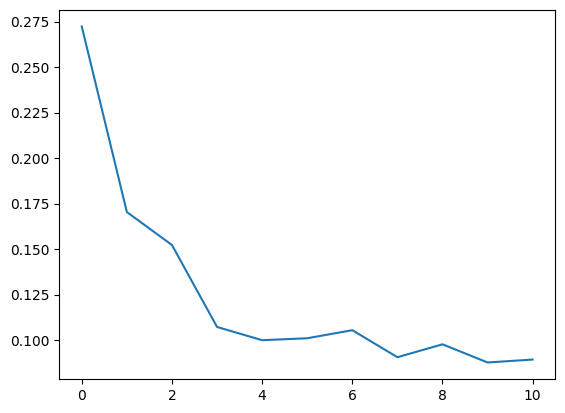

In [32]:
importlib.reload(data)
from data import TAPDataLoader

importlib.reload(models)
from models import TAPLSTM, EALSTM, LSTM

importlib.reload(train)
from train import Trainer

# Model config is a bit more dynamic
model_name = cfg['model'].lower()
if model_name == 'taplstm':
    model_fn = TAPLSTM
    cfg['model_args']['daily_in_size'] = len(dataset.daily_features)
    cfg['model_args']['irregular_in_size'] = len(dataset.irregular_features)
    cfg['model_args']['static_in_size'] = len(dataset.static_features)
elif model_name == 'transformer':
    
else:
    raise ValueError("Please provide a valid model name (taplstm, ealstm, tealstm)")

dataloader = TAPDataLoader(cfg, dataset)
trainer = Trainer(cfg, dataloader, model_fn)
trainer.start_training()

In [47]:
importlib.reload(evaluate)
from evaluate import predict

dataloader.set_mode(data_subset="test", basin_subset=["sag_daily_data"])
results = predict(trainer.model, dataloader)
basin_results = results.droplevel('basin').sort_index()

  0%|          | 0/103 [00:00<?, ?it/s]

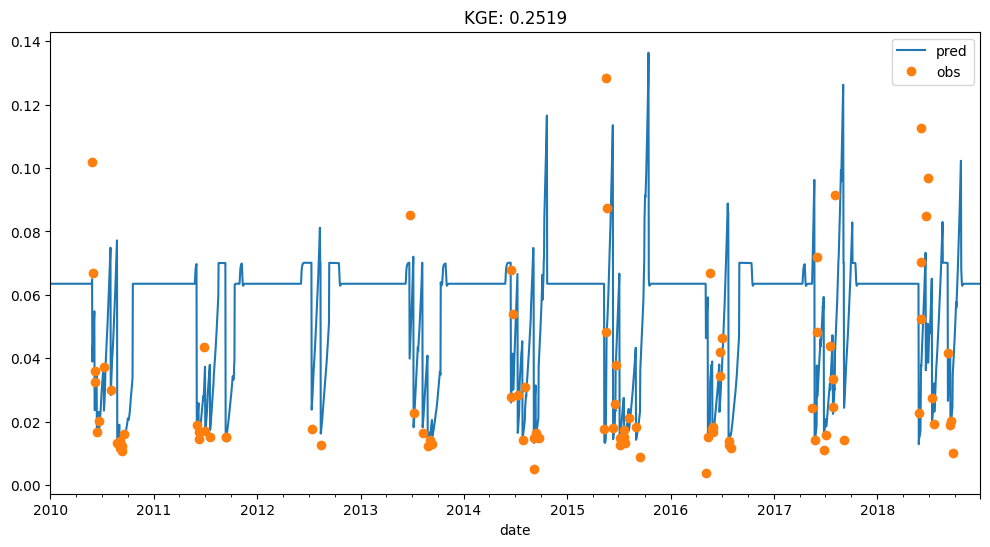

In [48]:
metrics = evaluate.get_all_metrics(basin_results['obs'],basin_results['pred'])

# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
basin_results['pred'].plot(ax=ax)
basin_results['obs'].plot(ax=ax,linestyle='None',marker='o')

plt.title(f"KGE: {metrics['kge']:0.4f}")
plt.legend()
plt.show()

In [39]:
basin_results

obs      pred
basin          date                     
sag_daily_data 2020-01-01  NaN  0.027141
               2020-01-02  NaN  0.027141
               2020-01-03  NaN  0.027141
               2020-01-04  NaN  0.027141
               2020-01-05  NaN  0.027141
...                        ...       ...
               2022-11-10  NaN  0.027141
               2022-11-11  NaN  0.027141
               2022-11-12  NaN  0.027141
               2022-11-13  NaN  0.027141
               2022-11-14  NaN  0.027141

[1049 rows x 2 columns]